 # Baseline Median Prediction


The below solution is a simple baseline created by calculating median meter reading values for each building and meter type and then appending them directly to the test set. The idea comes from the assumption that the future meter readings will be similar to the meter readings in the past for each building and meter type.

Inspiration for this solution comes from the past kaggle competition https://www.kaggle.com/c/web-traffic-time-series-forecasting which was also a time series forecasting problem. There were more than 100,000 separate time series that had to be used to predict future web traffic per page. A few solutions used the median visits over week time periods and one of the high placing solutions used the median predictions as features for modeling.

https://www.kaggle.com/safavieh/median-estimation-by-fibonacci-et-al-lb-44-9
https://www.kaggle.com/chechir/weekend-flag-median-with-wiggle
https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/44729#latest-305761


 ## What's Old is New Again  
 
The solution achieves a public LB of 1.61. This solution is certainly not high performing in the long run but it proves that a simple baseline is a good place to start. For time series forecasting, the most naive assumption for a baseline is that your future values will be the same as what you have seen previously. 

Data cleaning, feature engineering, feature selection, cross-validation and model selection are as important as ever in this competition but if your model cannot outperform this naive method, you need to rethink your approach.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# No modeling packages required

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv


---

### 1. Read in the Data
In this solution, we will only need the training csv and the test csv as we are only interested in the meter reading values themselves. I will not read in the weather data or building metadata at all.

In [2]:
PATH = '/kaggle/input/ashrae-energy-prediction/train.csv'
df = pd.read_csv(PATH)
df.head().append(df.tail())

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575
20216099,1448,0,2016-12-31 23:00:00,2.850


From looking at the training data, we can see that we have a year of data in hour increments from 00:00 01/01/2016 to 23:00 12/31/2016. The data represents separate time series for each of the 1448 buildings and the 4 meter types.

In [3]:
PATH = '/kaggle/input/ashrae-energy-prediction/test.csv'
test = pd.read_csv(PATH)
test.head().append(test.tail())

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00
41697599,41697599,1448,0,2018-05-09 07:00:00


From looking at the testing data, we can see that we are predicting nearly a year and a half of data in hour increments from 00:00 01/01/2017 to 23:00 05/09/2018. In this problem, we are predicting more in the future than we have data for.

---

### 2. Visualize Each Meter Type
In addition to the 1448 buildings, the dataset has 4 different types of energy meter: electric, chilled water, steam and hot water. Not every building has every meter type but each building that has more than one type has a different time series for each type of meter. Below are representative visualizations of each of the meter types. Note that each meter type time series has a different pattern, measurement scale and seasonality. This means that we will have to account for the meter type in addition to the building number for our calculation.


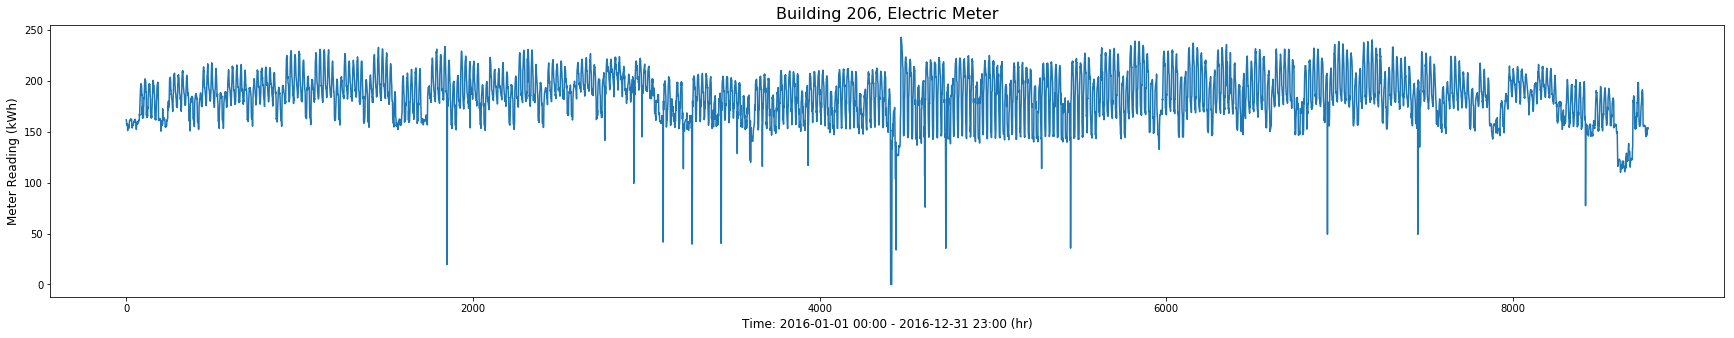

In [4]:
# Meter 0: Electric 
ts = df.loc[df['building_id']== 206]
ts = ts.loc[ts['meter']== 0]
N = len(ts)
ts['t'] = range(N)
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=ts)
plt.xlabel("Time: 2016-01-01 00:00 - 2016-12-31 23:00 (hr)", size = 12)
plt.ylabel("Meter Reading (kWh)", size = 12)
plt.title('Building 206, Electric Meter', size = 16)
plt.show()

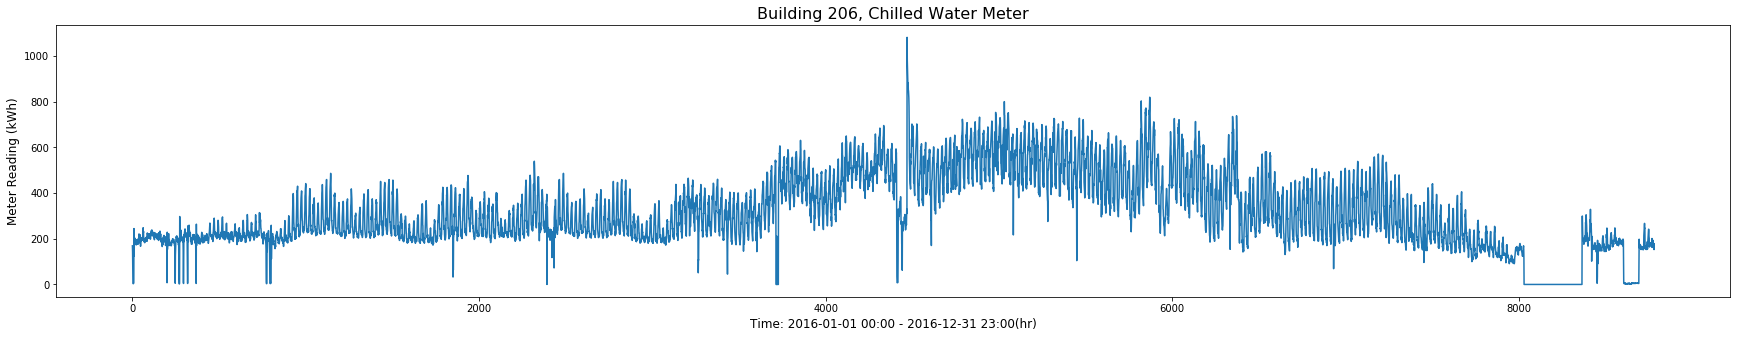

In [5]:
# Meter 1: Chilled Water
ts = df.loc[df['building_id']== 206]
ts = ts.loc[ts['meter']== 1]
N = len(ts)
ts['t'] = range(N)
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=ts)
plt.xlabel("Time: 2016-01-01 00:00 - 2016-12-31 23:00(hr)", size = 12)
plt.ylabel("Meter Reading (kWh)", size = 12)
plt.title('Building 206, Chilled Water Meter', size = 16)
plt.show()

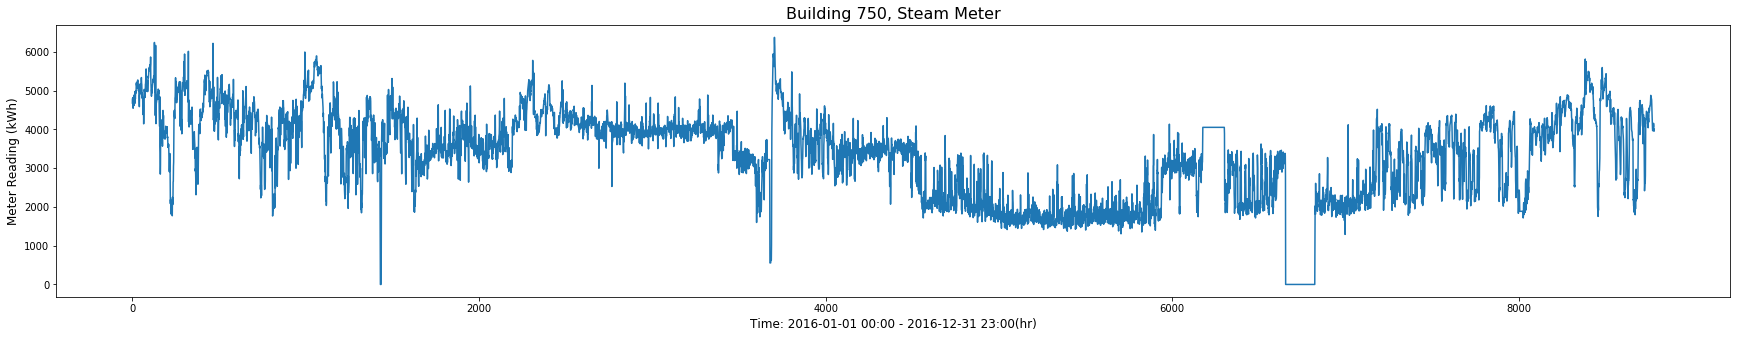

In [6]:
# Meter 2: Steam
ts = df.loc[df['building_id']== 750]
ts = ts.loc[ts['meter']== 2]
N = len(ts)
ts['t'] = range(N)
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=ts)
plt.xlabel("Time: 2016-01-01 00:00 - 2016-12-31 23:00(hr)", size = 12)
plt.ylabel("Meter Reading (kWh)", size = 12)
plt.title('Building 750, Steam Meter', size = 16)
plt.show()

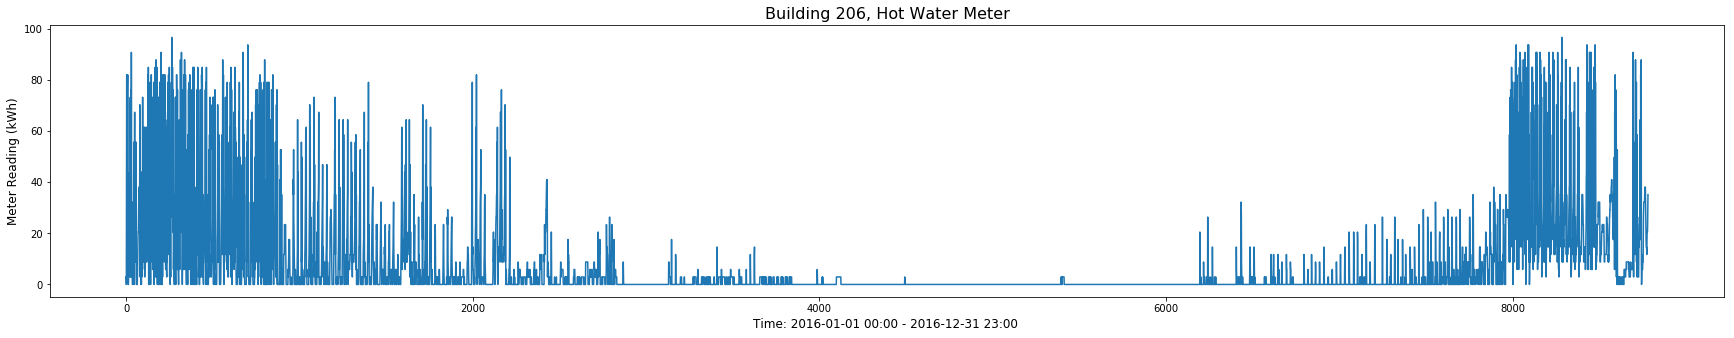

In [7]:
# Meter 3: Hot Water
ts = df.loc[df['building_id']== 206]
ts = ts.loc[ts['meter']== 3]
N = len(ts)
ts['t'] = range(N)
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=ts)
plt.xlabel("Time: 2016-01-01 00:00 - 2016-12-31 23:00 ", size = 12)
plt.ylabel("Meter Reading (kWh)", size = 12)
plt.title('Building 206, Hot Water Meter', size = 16)

plt.show()

---

### 3. Calculate Median Meter Readings of Training Set

We will be creating two new features from the timestamp: week and hour. This will allow us to group by building, meter, week and hour to calculate the median.

In [8]:
# Set up variables of column names
time = 'timestamp'
target = 'meter_reading'
building = 'building_id'
meter = 'meter'
week = 'week'
hr = 'hour'
pred = 'prediction'
target = 'meter_reading'

In [9]:
# Convert time stamp to datetime 
df[time] = pd.to_datetime(df[time])
test[time] = pd.to_datetime(test[time])

In [10]:
# Split time stamp into week and hour features
df[week] = df[time].dt.week
df[hr] = df[time].dt.hour

test[week] = test[time].dt.week
test[hr] = test[time].dt.hour

print(df.head())
print(test.head())

   building_id  meter  timestamp  meter_reading  week  hour
0            0      0 2016-01-01            0.0    53     0
1            1      0 2016-01-01            0.0    53     0
2            2      0 2016-01-01            0.0    53     0
3            3      0 2016-01-01            0.0    53     0
4            4      0 2016-01-01            0.0    53     0
   row_id  building_id  meter  timestamp  week  hour
0       0            0      0 2017-01-01    52     0
1       1            1      0 2017-01-01    52     0
2       2            2      0 2017-01-01    52     0
3       3            3      0 2017-01-01    52     0
4       4            4      0 2017-01-01    52     0


In [11]:
# Group by building id, meter type, week and hour. Then calculate median value for each group and make a new series called prediction from this. 

group = [building, meter, week, hr]
gp = df.groupby(group)[[target]].median().rename({target:pred},axis=1)

We can do this because we only have one year of data so we are assuming that the predicted data will be the same as the old data for each week and hour. 
However, since we are predicting January - May twice in the test set, we will be repeating some of the predicted values.

In [12]:
gp.head().append(gp.tail())

prediction
building_id meter week hour            
0           0     1    0          0.000
                       1          0.000
                       2          0.000
                       3          0.000
                       4          0.000
1448        0     53   19         3.275
                       20         2.900
                       21         3.000
                       22         2.600
                       23         2.800

In [13]:
# Merge the predictions to the test set to align timestamps again
test = test.merge(gp, on=group, how='left')
test

,row_id,building_id,meter,timestamp,week,hour,prediction
0,0,0,0,2017-01-01 00:00:00,52,0,224.90350
1,1,1,0,2017-01-01 00:00:00,52,0,92.69165
2,2,2,0,2017-01-01 00:00:00,52,0,5.52875
3,3,3,0,2017-01-01 00:00:00,52,0,170.29850
4,4,4,0,2017-01-01 00:00:00,52,0,1140.56000
...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,19,7,4.75000
41697596,41697596,1445,0,2018-05-09 07:00:00,19,7,5.90000
41697597,41697597,1446,0,2018-05-09 07:00:00,19,7,0.95000
41697598,41697598,1447,0,2018-05-09 07:00:00,19,7,172.42500


### 4. Read in Submission File and Append Predictions

In [14]:
# Read in submission file
PATH = '/kaggle/input/ashrae-energy-prediction/sample_submission.csv'
sub = pd.read_csv(PATH)
sub.head().append(sub.tail())

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0
41697599,41697599,0


In [15]:
# Check that submission ids match test set ids 
# Add in median predictions to submission as target
print(len(sub))
print(len(test))
print((sub['row_id'] == test['row_id']).all())

# Forward fill and back fill nans as a precaution
sub[target] = test[pred].ffill().bfill()


41697600
41697600
True


In [16]:
sub[[target]]

,meter_reading
0,224.90350
1,92.69165
2,5.52875
3,170.29850
4,1140.56000
...,...
41697595,4.75000
41697596,5.90000
41697597,0.95000
41697598,172.42500


In [17]:
# Write csv for submission
PATH = 'submission.csv'
sub.to_csv(PATH, index=False)

In [18]:
sub.head().append(sub.tail())

,row_id,meter_reading
0,0,224.90350
1,1,92.69165
2,2,5.52875
3,3,170.29850
4,4,1140.56000
41697595,41697595,4.75000
41697596,41697596,5.90000
41697597,41697597,0.95000
41697598,41697598,172.42500
41697599,41697599,4.20000


In [19]:
# Final check for nan values in submission
sub.isna().any()

row_id           False
meter_reading    False
dtype: bool

In [20]:
np.isinf(sub).any()

row_id           False
meter_reading    False
dtype: bool